In [57]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# библиотека для преобразованя категориальных признаков
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [58]:
df = pd.read_csv('dataset.csv', sep=',')

In [59]:
df.head()

,client_id,date_reg,market,group,archetype,hardware,channel,dealer,phone,type_t,...,all_calls_num,all_calls_dur,quantity_recharge,recharges_sum,last_day_recharge,mean_recharges_sum,mean_balance,start_balance,final_balance,difference_balance
0,09777552-cc75-4f03-9438-11c3a7480f97,2016-05-10,R25,PP1_9,PP2_0,PPT1,C1_22,C2_22,D2254,DT1_6,...,19.0,6506.0,1.0,1001.11200,1.0,1001.112000,1202.535734,2269.187200,1.334816,-2267.852384
1,5fbe2ea9-0c80-4164-b703-416b85c23d8c,2016-04-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,NAN,NAN,...,546.0,27599.0,2.0,5526.13824,13.0,2763.069120,1006.985190,2378.642112,447.830768,-1930.811344
2,8cbd48c0-8f90-4f08-bef7-8f09d9924e55,2016-05-19,R25,PP1_9,PP2_0,PPT1,C1_6,C2_0,D2594,DT1_6,...,476.0,141308.0,9.0,7014.45808,30.0,779.384231,291.946506,1134.593600,1355.505648,220.912048
3,ffda8d15-cd38-45c3-84ba-29a9811ed79e,2016-05-28,R25,PP1_9,PP2_0,PPT1,C1_22,C2_11,D3131,DT1_6,...,31.0,2931.0,0.0,0.00000,0.0,0.000000,406.673941,1268.075200,-40.044480,-1308.119680
4,1f9618ad-a980-4110-af32-9741e491a728,2016-05-23,R4,PP1_9,PP2_0,PPT1,C1_28,C2_21,D454,DT1_6,...,9.0,213.0,1.0,6674.08000,1.0,6674.080000,0.000000,0.000000,0.000000,0.000000


In [60]:
# приведение дат к нужному типу
df['date_reg'] = pd.to_datetime(df['date_reg'], format="%Y-%m-%d")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_id              240000 non-null  object        
 1   date_reg               240000 non-null  datetime64[ns]
 2   market                 240000 non-null  object        
 3   group                  240000 non-null  object        
 4   archetype              240000 non-null  object        
 5   hardware               240000 non-null  object        
 6   channel                240000 non-null  object        
 7   dealer                 240000 non-null  object        
 8   phone                  240000 non-null  object        
 9   type_t                 240000 non-null  object        
 10  device                 240000 non-null  object        
 11  churn                  240000 non-null  int64         
 12  quantity_days_traffic  240000 non-null  int6

# Кодирование категориальных признаков
2 варианта: 
- Dummy
- LabelEncoder

In [62]:
df['date_reg_cat_feat'] = df['date_reg']

In [63]:
# список категориальных признаков
cat_feat = ['market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'phone', 'type_t', 'device', 'date_reg_cat_feat']

In [64]:
# количество унакальных значений  категориальных признаков
print('Количество унакальных значений категориальных признаков:')
for i in cat_feat:
      print(i, ' : ', len(set(df[i].tolist())))

Количество унакальных значений категориальных признаков:
market  :  84
group  :  46
archetype  :  17
hardware  :  2
channel  :  35
dealer  :  24
phone  :  3353
type_t  :  14
device  :  8
date_reg_cat_feat  :  61


Много уникальных значений признака 'phone'. Не получается перевести в разряженную матрицу (dummy)

## LabelEncoder

In [65]:
df_le = df.copy()
le = LabelEncoder()
for i in cat_feat:
    le.fit(df_le[i].tolist())
    cat_trsfm = le.transform(df_le[i].tolist())
    se = pd.Series(cat_trsfm)
    df_le[i+'_le'] = se.values
    del df_le[i]

# del df_le['phone']

### train - test LabelEncoder

In [66]:
X_train_le = df_le[df_le['date_reg'] < '2016-05-13']
X_test_le = df_le[df_le['date_reg'] >= '2016-05-13']

y_train_le = X_train_le[['client_id', 'churn']]
y_test_le = X_test_le[['client_id', 'churn']]

del X_train_le['churn']
del X_test_le['churn']
del X_train_le['date_reg']
del X_test_le['date_reg']


X_train_le = X_train_le.set_index('client_id')
y_train_le = y_train_le.set_index('client_id')
X_test_le = X_test_le.set_index('client_id')
y_test_le = y_test_le.set_index('client_id')

## OneHotEncoder (Dummy)

In [67]:
df_dummy = df.copy()

# исключаю признак 'phone' для dummy-кодирования из-за большого количества уникальных значений 
cat_feat.remove('phone')

ohe = OneHotEncoder(sparse=False) 
for j in cat_feat:
    new_ohe_features = ohe.fit_transform(df_dummy[j].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[j + '=' + str(i) for i in range(new_ohe_features.shape[1])], dtype='int64')
    df_dummy = pd.concat([df_dummy, tmp], axis=1)
    del df_dummy[j]

del df_dummy['phone']

In [68]:
df_dummy.shape

(240000, 314)

### train - test Dummy

In [69]:
X_train_dummy = df_dummy[df_dummy['date_reg'] < '2016-05-13']
X_test_dummy = df_dummy[df_dummy['date_reg'] >= '2016-05-13']

y_train_dummy = X_train_dummy[['client_id', 'churn']]
y_test_dummy = X_test_dummy[['client_id', 'churn']]

del X_train_dummy['churn']
del X_test_dummy['churn']
del X_train_dummy['date_reg']
del X_test_dummy['date_reg']


X_train_dummy = X_train_dummy.set_index('client_id')
y_train_dummy = y_train_dummy.set_index('client_id')
X_test_dummy = X_test_dummy.set_index('client_id')
y_test_dummy = y_test_dummy.set_index('client_id')

# XGBoost

## 1. xgb Dummy

In [70]:
%%time 
xgb = XGBClassifier()
xgb.fit(X_train_dummy, y_train_dummy)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wall time: 3min 54s


XGBClassifier()

In [71]:
xgb_valid_pred = xgb.predict(X_test_dummy)

In [72]:
roc_auc_score(y_test_dummy, xgb_valid_pred)

0.78014272549331

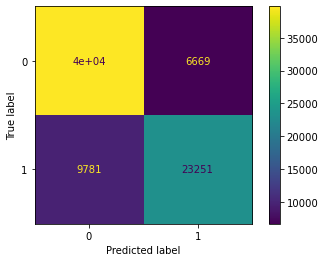

In [73]:
plot_confusion_matrix(xgb, X_test_dummy, y_test_dummy)
plt.show()

## 2. xgb LabelEncoder

In [74]:
%%time 
xgb = XGBClassifier()
xgb.fit(X_train_le, y_train_le)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wall time: 34.2 s


XGBClassifier()

In [75]:
xgb_le_valid_pred = xgb.predict(X_test_le)

In [76]:
roc_auc_score(y_test_le, xgb_le_valid_pred)

0.7802028285701667

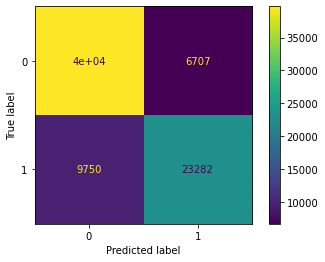

In [77]:
plot_confusion_matrix(xgb, X_test_le, y_test_le)
plt.show()